In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import nibabel as nb
import random
from sklearn.linear_model import LinearRegression
import cv2

In [2]:
mri_file = glob('/Volumes/DISK_IMG/100610/m100610_T1w.nii.gz')[0]
mri_im = nb.load(mri_file)
# mri_hdr = mri_im.header
mri_data = mri_im.get_fdata()

In [3]:
sos_file = glob('/Volumes/DISK_IMG/100610/Vp.nii.gz')[0]
sos_im = nb.load(sos_file)
# sos_hdr = sos_im.header
sos_data = sos_im.get_fdata()

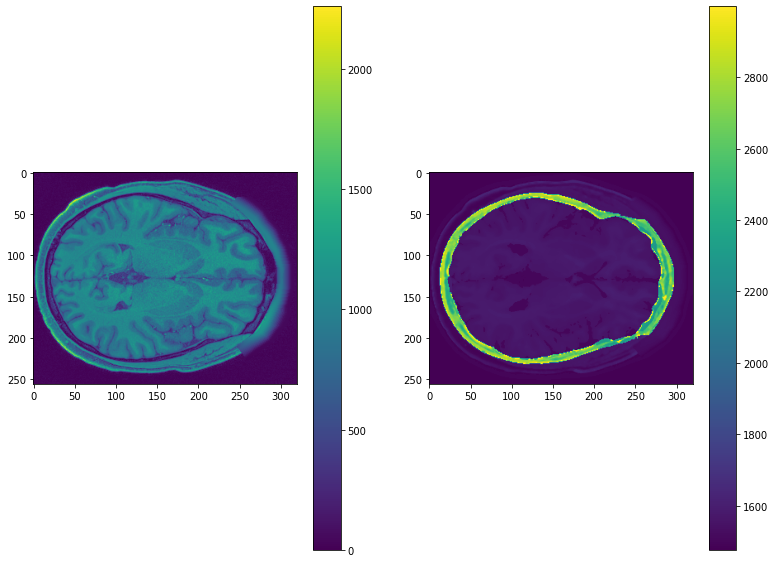

In [536]:
mri_slice = np.array(mri_data[:,:,150])
sos_slice = np.array(sos_data[:,:,150])

fig, (ax1, ax2) = plt.subplots(figsize=(13, 10), ncols=2)

pos = ax1.imshow(mri_slice)
fig.colorbar(pos, ax=ax1)
pos = ax2.imshow(sos_slice)
fig.colorbar(pos, ax=ax2)

In [537]:
def make_ellipse(parameters, x, y):
    c_x = parameters[0]
    c_y = parameters[1]
    r_x = parameters[2]
    r_y = parameters[3]
    
    a = (x - c_y)**2
    b = (r_y**2)
    c = (y - c_x)**2
    d = (r_x**2)
    
    ellipse = (a/b) + (c/d)
    return ellipse

def preprocess(mri_slice, sos_slice, params1, params2):
    c_x_1 = params1[0]
    c_y_1 = params1[1]
    r_x_1 = params1[2]
    r_y_1 = params1[3]
    c_x_2 = params2[0]
    c_y_2 = params2[1]
    r_x_2 = params2[2]
    r_y_2 = params2[3]

    # visualising the ellipse we'll be using
    t = np.linspace(0, 2*np.pi, 200)
    x_1 = c_x_1 + r_x_1 * np.cos(t)
    y_1 = c_y_1 + r_y_1 * np.sin(t)
    x_2 = c_x_2 + r_x_2 * np.cos(t)
    y_2 = c_y_2 + r_y_2 * np.sin(t)

    better_mri = []
    mri_flat = []
    sos_flat = []
    for x in range(len(mri_slice[:,0])): # from 0 to 256
        for y in range(len(mri_slice[0,:])): # from 0 to 319
            # remove all skull (pixels below 250 between two ellipses) make_ellipse([c_x_1,c_y_1,r_x_1,r_y_1], x, y) < 1) and 
            if((make_ellipse([c_x_2,c_y_2,r_x_2,r_y_2], x, y) >= 1) and (sos_slice[x,y] >= 1700)):
                better_mri.append(10000) # this is only used for the visualization
            # remove background
            elif((make_ellipse([c_x_1,c_y_1,r_x_1,r_y_1], x, y) >= 1) and (mri_slice[x,y] < 250)):
                better_mri.append(10000)
            else:
                better_mri.append(mri_slice[x,y])
                mri_flat.append(mri_slice[x,y])
                sos_flat.append(sos_slice[x,y])

    plt.imshow(np.array(better_mri).reshape([256,320]))
    plt.plot(x_1, y_1, c='w')
    plt.plot(x_2, y_2, c='w')

    print(len(mri_flat))

    # mri_slice = mri_slice.flatten()
    # sos_slice = sos_slice.flatten()
    # mri_flat = []
    # sos_flat = []
    # for i in range(len(better_mri)):
    #     if(better_mri[i] != 10000): 
    #         mri_flat.append(mri_slice[i])
    #         sos_flat.append(sos_slice[i])

    return mri_flat, sos_flat

51440


51440

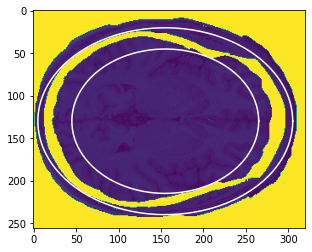

In [544]:
mri_flat, sos_flat = preprocess(mri_slice, sos_slice, [155,130,150,110], [155,130,110,85])
len(mri_flat)

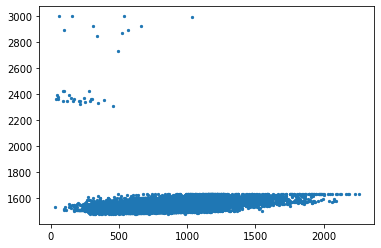

In [545]:
plt.scatter(mri_flat, sos_flat, s=5)

In [546]:
def analyse_linearity(mri_slice, sos_slice):
    # start: train-test split (70% train, 30% test)
    mri_slice = pd.Series(mri_slice).fillna(0)
    sos_slice = pd.Series(sos_slice).fillna(0)
    
    train_X = pd.DataFrame()
    train_y = pd.DataFrame()
    train_indices = []
    for i in range(int(0.7*mri_slice.shape[0])):
        # get 70% of the set for training from the whole thing randomly
        r = random.randint(0, mri_slice.shape[0]-1) 
        train_indices.append(r)
        train_X = train_X.append(pd.Series(mri_slice.iloc[r]), ignore_index=True)
        train_y = train_y.append(pd.Series(sos_slice.iloc[r]), ignore_index=True)

    test_X = pd.DataFrame()
    test_y = pd.DataFrame()
    test_indices = []
    while test_y.shape[0] < 0.30*mri_slice.shape[0]:
        r = random.randint(0, mri_slice.shape[0]-1)
        if(r not in train_indices): 
            test_indices.append(r)
            test_X = test_X.append(pd.Series(mri_slice.iloc[r]), ignore_index=True)
            test_y = test_y.append(pd.Series(sos_slice.iloc[r]), ignore_index=True)

    train_X = np.array(train_X).reshape(-1,1) # this is necessary for the linear regression
    train_y = np.array(train_y).reshape(-1,1)
    test_X = np.array(test_X).reshape(-1,1)
    test_y = np.array(test_y).reshape(-1,1)
    # end: train-test split

    # linear regression training & prediction
    linear = LinearRegression()
    linear.fit(train_X, train_y)
    preds = linear.predict(test_X)
    coef = linear.coef_
    intercept = linear.intercept_
    r2 = linear.score(test_y, preds)

    return coef, intercept, r2, [test_X, test_y]

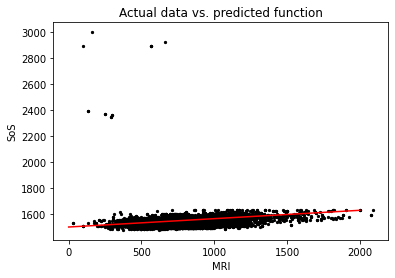

Coefficient: 0.06432529775391935
Intercept: 1499.3700726177183
R2: -9.02793235519784


In [547]:
coef, intercept, r2, data = analyse_linearity(mri_flat, sos_flat)
x = np.linspace(0,2000)
y = coef * x + intercept

plt.figure()
plt.scatter(data[0], data[1], c='black', s=5)
plt.plot(x, y[0], '-r')
plt.title("Actual data vs. predicted function")
plt.xlabel("MRI")
plt.ylabel("SoS")
plt.show()

print("Coefficient: " + str(coef[0][0]))
print("Intercept: " + str(intercept[0]))
print("R2: " + str(r2))